# API Keys

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

# Chatbot w/ Summarizing Messages and Memory

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [3]:
from langgraph.graph import MessagesState

class State(MessagesState):
    summary: str

## Nodes

In [7]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Nodes
def call_model(state: State) -> State:
    summary = state.get("summary", "")

    if summary:
        system_message = f"Summary of conversation earlier: {summary}"

        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    return {"messages": llm.invoke(messages)}

def summarize_conversation(state: State) -> State:
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is summary of the onversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    new_summary = llm.invoke(messages)

    delete_messages = [RemoveMessage(id=message.id) for message in state["messages"]]

    return {"summary": new_summary, "messages": delete_messages}


In [12]:
from typing import Literal
from langgraph.graph import StateGraph, START, END

def is_messages_too_long(state: State) -> Literal["summarize_conversation", "__end__"]:
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_conversation"
    
    return END

## Adding Memory

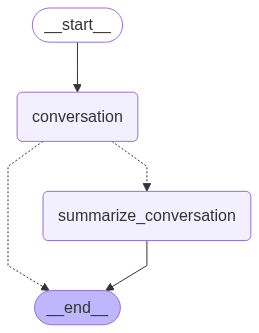

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# Build graph
builder = StateGraph(State)
builder.add_node("conversation", call_model)
builder.add_node("summarize_conversation", summarize_conversation)

# Logic
builder.add_edge(START, "conversation")
builder.add_conditional_edges("conversation", is_messages_too_long)
builder.add_edge("summarize_conversation", END)

# Add
graph = builder.compile(checkpointer=MemorySaver())

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

In [27]:
from random import random

# Create a thread
config = {"configurable": {"thread_id": random()}}

# Start conversation
input_message = HumanMessage(content="Hi! I'm Tiago.")
output = graph.invoke({"messages": [input_message]}, config)

for message in output["messages"][-1:]:
    message.pretty_print()

input_message = HumanMessage(content="What's my name?")
output = graph.invoke({"messages": [input_message]}, config)

for message in output["messages"][-1:]:
    message.pretty_print()

input_message = HumanMessage(content="I like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)

for message in output["messages"][-1:]:
    message.pretty_print()

================================== Ai Message ==================================

Hi Tiago! It's nice to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Tiago!
================================== Ai Message ==================================

That's awesome, Tiago! The San Francisco 49ers are a team with a really rich history and a passionate fanbase.

What do you like most about them, or what's your favorite memory as a fan?


In [28]:
graph.get_state(config).values.get("summary", "")

''

In [29]:
input_message = HumanMessage(content="I like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config)

for message in output["messages"][-1:]:
    message.pretty_print()

In [30]:
graph.get_state(config).values.get("summary", "")

AIMessage(content="Here's a summary of our conversation so far:\n\nThe conversation began with you, Tiago, introducing yourself, and I confirmed your name when you asked. You then shared your enthusiasm for the San Francisco 49ers, specifically mentioning your admiration for Nick Bosa and asking if he was the highest-paid defensive player. I confirmed that when he signed his contract in September 2023, he became the highest-paid non-quarterback in NFL history.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--36c35b29-5524-4721-bbfc-454b899f7d84-0', usage_metadata={'input_tokens': 208, 'output_tokens': 753, 'total_tokens': 961, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 656}})

## External Memory

In [45]:
import sqlite3

# Feed path to save locally
conn = sqlite3.connect(":memory:")

In [46]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

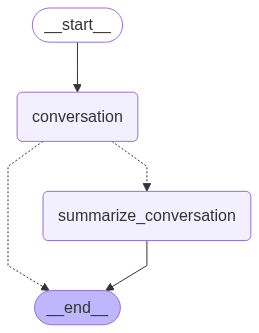

In [47]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# Build graph
builder = StateGraph(State)
builder.add_node("conversation", call_model)
builder.add_node("summarize_conversation", summarize_conversation)

# Logic
builder.add_edge(START, "conversation")
builder.add_conditional_edges("conversation", is_messages_too_long)
builder.add_edge("summarize_conversation", END)

# Add
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
from random import random

# Create a thread
config = {"configurable": {"thread_id": 1}}

# Start conversation
input_message = HumanMessage(content="Hi! I'm Tiago.")
output = graph.invoke({"messages": [input_message]}, config)

for message in output["messages"][-1:]:
    message.pretty_print()

input_message = HumanMessage(content="What's my name?")
output = graph.invoke({"messages": [input_message]}, config)

for message in output["messages"][-1:]:
    message.pretty_print()

input_message = HumanMessage(content="I like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)

for message in output["messages"][-1:]:
    message.pretty_print()

ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 127359338012800 and this is thread id 127356433815232.

In [35]:
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '0.8018119297788188'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())